In [365]:
import flymovie as fm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.ndimage as ndi
from scipy.optimize import curve_fit
%load_ext autoreload
%autoreload 2

def real_nonzero_min(x):
    x1 = x[np.isfinite(x)]
    x1 = x1[x1 > 0]
    good_min = np.min(x1)
    return good_min

def double_n_binom(x, a1, r1, p1, a2, r2, p2):
    out = a1 * fm.n_binom_pdf(x, r1, p1) + a2 * fm.n_binom_pdf(x, r2, p2)
    min_ = real_nonzero_min(out)
    out[~np.isfinite(out)] = min_
    out[out == 0] = min_
    return np.log(out + real_nonzero_min(out))

def process_hist(pix): 
    ydata, xdata = np.histogram(pix, bins=500, range=(0,2_000))
    ydata = ydata / np.sum(ydata)
    xdata = xdata[:-1] + ((xdata[1] - xdata[0]) / 2)
    #return xdata, ydata
    return xdata, np.log(ydata + real_nonzero_min(ydata))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
stackfile = '/Volumes/stad3/2022-04-08/yw-match-20220318-rpb1-gfp-em2-03.czi'

In [5]:
stack = fm.read_czi(stackfile, swapaxes=False)
sm = ndi.gaussian_filter(stack, (1,10,10))

In [199]:
t=280
fm.viewer(np.where(sm < t, stack, 0), 15)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

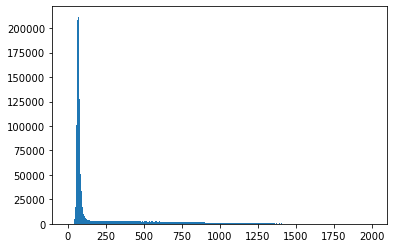

In [489]:
pix = stack[sm < t]
plt.hist(pix, 500, range=(0,2_000), log=False);

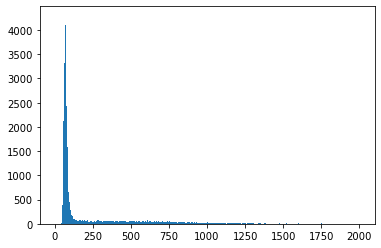

In [488]:
pix = stack[22][sm[22] < t]
plt.hist(pix, 500, range=(0,2_000), log=False);

5.339205035083916e-07


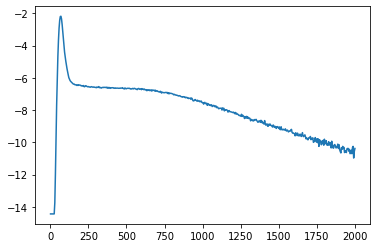

In [235]:
xdata, ydata = process_hist(pix)
plt.plot(xdata, ydata);

In [247]:
# a1, r1, p1, a2, r2, p2
xdata, ydata = process_hist(pix)
a = curve_fit(double_n_binom, xdata[:250], ydata[:250], maxfev=10_000, bounds=([0,0,0,0,0,0],[np.inf,np.inf,1,np.inf,np.inf,1]), x_scale=(1, 30, 0.1, 1, 30, 0.1), method="trf", ftol=1e-10)
#a = curve_fit(double_n_binom, xdata, ydata, maxfev=10_000, p0=(0.13, 1.65, 0.003, 2.6, 220, 0.75))
print(a[0])

[1.13809513e+00 4.02381768e+00 7.01174823e-03 2.42724905e+00
 7.38549717e+01 4.83464612e-01]


(0.0, 0.03)

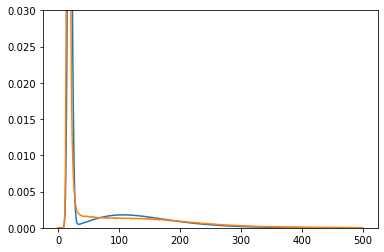

In [248]:
n=200
plt.plot(np.exp(double_n_binom(xdata, *a[0])))
#plt.plot(np.exp(double_n_binom(xdata, 0.9, 1.9, 0.0047, 2.52913620e+00, 8.91875355e+01, 5.36197186e-01)))
plt.plot(np.exp(ydata))
plt.ylim((0,0.03))

In [326]:
def gamma_pdf(x, k, theta):
    numerator = (x ** (k - 1) * np.exp(-1 * x / theta))
    denom = (theta ** k) * scipy.special.gamma(k)
    return numerator / denom

def double_gamma(x, a1, k1, theta1, a2, k2, theta2):
    out = (a1 * gamma_pdf(x, k1, theta1)) + (a2 * gamma_pdf(x, k2, theta2))
    min_ = real_nonzero_min(out)
    out[~np.isfinite(out)] = min_
    out[out == 0] = min_
    return np.log(out + real_nonzero_min(out))

def double_gamma(x, a1, b1, k1, theta1, a2, b2, k2, theta2):
    dg = (a1 * gamma_pdf(b1 * x, k1, theta1)) + (a2 * gamma_pdf(b2 * x, k2, theta2))
    return dg

In [291]:
double_gamma(np.arange(10),1,1,1,1,1,1)

array([2.00000000e+00, 7.35758882e-01, 2.70670566e-01, 9.95741367e-02,
       3.66312778e-02, 1.34758940e-02, 4.95750435e-03, 1.82376393e-03,
       6.70925256e-04, 2.46819608e-04])

In [373]:
def gamma(x, a1, b1, k, theta):
    return a1 * gamma_pdf(b1 * x, k, theta)

xdata, ydata = process_hist(pix)
a = curve_fit(gamma, xdata[:150], ydata[:150], maxfev=10_000, p0=(1,0.1,1.5,2))
print(a[0])

[ 82.92024447  17.4562772   69.11664043 296.43607599]


/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_11924/1122106933.py:2: RuntimeWarning: overflow encountered in power
  numerator = (x ** (k - 1) * np.exp(-1 * x / theta))
/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_11924/1122106933.py:3: RuntimeWarning: overflow encountered in double_scalars
  denom = (theta ** k) * scipy.special.gamma(k)
/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_11924/1122106933.py:4: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denom


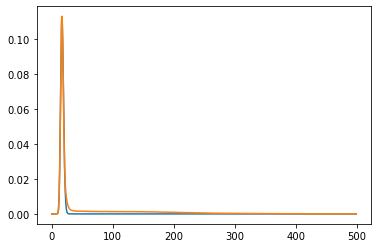

In [361]:
n=200
plt.plot(gamma(xdata, *a[0]))
plt.plot(ydata)
#plt.ylim((0,0.03))

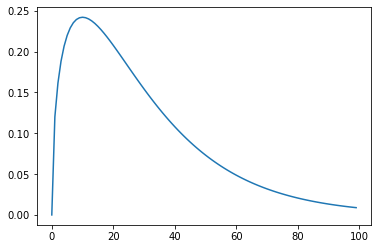

In [344]:
plt.plot(gamma_pdf(np.arange(0,10, 0.1), 1.5, 2))

In [412]:
def double_gamma(x, a1, b1, k1, theta1, a2, b2, k2, theta2):
    out = (a1 * gamma_pdf(b1 * x, k1, theta1)) + (a2 * gamma_pdf(b2 * x, k2, theta2))
    min_ = real_nonzero_min(out)
    out[~np.isfinite(out)] = min_
    out[out == 0] = min_
    return np.log(out + real_nonzero_min(out))

xdata, ydata = process_hist(pix)
a = curve_fit(double_gamma, xdata[:350], ydata[:350], maxfev=10_000, 
        p0=(1,0.1,1.5,2, 0.1,0.1,1.5,2), 
        bounds=([0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]),
        #x_scale=(1, 0.1, 0.1, 1, 30, 0.1), 
        method="trf", 
        ftol=1e-9
        )
print(a[0])

[ 0.11353615  0.09654948  3.63831185 16.50105438  1.49042179  0.61946031
 35.02373945  1.38720559]


(0.0, 0.03)

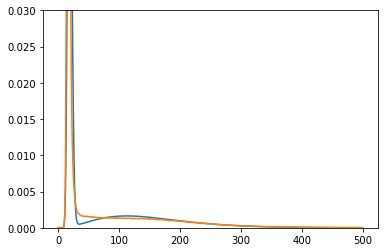

In [415]:
n=200
plt.plot(np.exp(double_gamma(xdata, *a[0])))
plt.plot(np.exp(ydata))
plt.ylim((0,0.03))

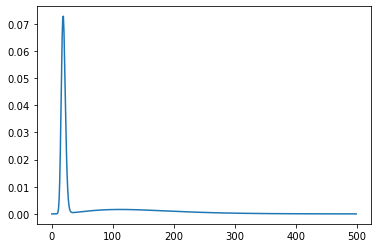

In [418]:
y = np.exp(double_gamma(xdata, *a[0]))
plt.plot(y)

In [467]:
y = np.exp(ydata)
y = y / np.sum(y)


return a vector of pixel values (normed to 1 GFP) and a vector of probabilities

In [428]:
from flymovie.simnuc import Sim

In [437]:
mask = Sim.make_spherical_mask(100,100,100, nuc_rad=38)
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')

In [484]:
sim = Sim(mask, 85, 85)
sim.add_n_objects(500, 100, 1, 1)
sim.add_noise('poisson')
sim.add_kernel(kernel, 100,50)
sim.convolve()
sim.resize((250,85,85))
sim.add_noise_custommodel(xdata/8, y)

In [485]:
fm.viewer(sim.im,2)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

In [450]:
fm.viewer(stack, 10)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

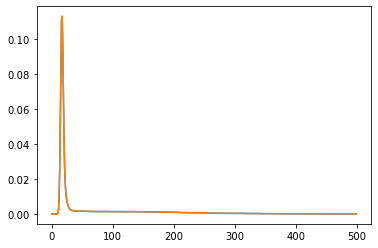

In [468]:
plt.plot(y)
plt.plot(np.exp(ydata))

In [487]:
np.sum(y[50:])

0.264057310676948

## Summary

So the noise I can measure in nuclei of "empty" embryos 1) can be modeled modestly well by either 2 negative binomials or 2 gamma distributions. But...it doesn't make very good images. Observations:
    1. Simulated images don't look like real images. They are too crisp.
    2. The magnitude of the noise measured in empty embryos is much less than the signal in GFP+ embryos, meaning that the additional blurring can't be explained by this noise.

I'm not sure exactly how to interpret this. I think what it's basically saying is that this noise exists but is insufficient to account for the added blurring that we are seeing. My best interpretation is something like: there are at least three sources of "noise" in our images. One is shot noise from photon emissions (minor), another is this detector/scatter/etc. noise that we can measure in empty embryos (also fairly minor), and a third is an additional blurring that I suspect (v. unsure) may come from the inaccuracy of our PSF. A sample and depth-variant PSF would be considerably "worse" than the bead-measured PSF. So what to do?

Option 1: ideal option would be to find a way to measure PSFs as a function of sample and depth. This seems hard but a cool future plan maybe?

Option 2: adding gaussian noise seems to do a surprisingly good job of producing realistic-looking images. We can keep using this, and explain that it captures unspecified noise in the imaging system, and we "learn" the amount of this noise. This would probably require pivoting back to measuring concentrations (# molecules). One idea here would be to show that the number of molecules and noise vary together, so we simulate a certain protein at several concentrations and show we get the same answer with scaled noise factors.

Option 3: Learn a noise model. Essentially, learn a sample-depth PSF. I think we would need to image a sample of some known composition, include noise, and learn a PSF that varies with depth. The nanocages is a good idea here, but the movement is an issue. Bicoid nuclei are theoretically bags of known concentration. Could it be useful to embed larger beads that aren't as mobile? Even if they're not sub-diffraction sized?


I think option 2 is the best. I think the steps are to estimate the number of molecules, learn the noise from simulations. Could use other non-gaussian models, potentially.


## Back to concentration estimation

In [496]:
kernel_peak = 25_000
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel_rs = ndi.zoom(kernel, (100/250, 50/85, 50/85), order=3)

In [497]:
fm.viewer(kernel * 1000, 5)
fm.viewer(kernel_rs * 1000, 5)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

In [529]:
kernel_peak = 27_000
n_gfps = 60 
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85), order=3)
kernel_1gfp = kernel * (kernel_peak / np.max(kernel)) / n_gfps
im = np.ones((100,100,100)) * 150/919
#im[10:-10, 10:-10, 10:-10] = 150/919

c = ndi.convolve(im, kernel_1gfp)

In [530]:
fm.viewer(c)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

1. Get peak height and n-gfp from matched stacks
1. Convert to 1-GFP PSF
1. segment nuclei (or a nucleus)
2. For nucleus, get total molecules, total pix, concentration.

In [661]:
kernel_peak = 28_000
n_gfps = 60
# 34 for egfp, 93 for mneon, 54 for sfgfp
brightness = 93

n_gfp_equiv = n_gfps * rel_brightness
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85), order=3)
kernel_1gfp = kernel * (kernel_peak / np.max(kernel)) / n_gfps


In [674]:
stack = fm.read_czi('/Volumes/stad3/2022-03-21/26983-1-1-em2-16.czi', swapaxes=False)
#stack = stack[8:]

In [675]:
sm = ndi.gaussian_filter(stack, (2,5,5))
fm.viewer(sm, 5)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

In [676]:
t = 3400
mask = np.where(sm > t, 1, 0)
lmask, _ = ndi.label(mask)
#lmask = np.where(lmask > 1, lmask, 0)
fm.viewer(np.where(lmask, stack, 0), 6)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Gators', 'Greens', 'prism', 'c…

In [677]:
pix = stack[mask > 0]
num_pix = len(pix)
sum_ = np.sum(pix)
rel_brightness = brightness / 33.54
nmolecules = sum_ / np.sum(kernel_1gfp) / rel_brightness

L = 250e-9 * 85e-9 * 85e-9 * 1000 * num_pix # in liters
mols = nmolecules / 6.022e23
M = mols / L
nM = M / 1e-9
nM

60.30028913112657

### bicoid (25k - 60)
/Volumes/stad3/2022-03-18/bcd-gfp-em2-11.czi 155 nM (25k - 60)

### rpb1 (40k - 120)
/Volumes/stad3/2022-03-18/rpb1-gfp-em1-21.czi 385 nM (nc14)

/Volumes/stad3/2022-03-18/rpb1-gfp-em2-02.czi 335 nM (early, maybe nc11)

/Volumes/stad3/2022-03-18/rpb1-gfp-em2-06.czi (early)

### zld (25k - 60)
/Volumes/stad3/2022-03-18/zld-mneon-em1-01.czi 83 nM

/Volumes/stad3/2022-03-18/zld-mneon-em1-10.czi 79 nM

/Volumes/stad3/2022-03-18/zld-mneon-em1-14.czi 75 nM

### h2b (4k - 120)
/Volumes/stad3/2022-03-17/h2b-gfp-em1-11.czi 5000 nM

/Volumes/stad3/2022-03-17/h2b-gfp-em2-08.czi 4977 nM

### cp190 (20k - 60)

/Volumes/stad3/2022-03-24/cp190-em3-01.czi 215 nM

/Volumes/stad3/2022-03-24/cp190-em3-08.czi 218 nM

/Volumes/stad3/2022-03-24/cp190-em3-16.czi 212 nM

/Volumes/stad3/2022-03-24/cp190-em3-24.czi 210 nM

### zld cterm (28k - 60)

26983-1-1-em2-01.czi 86 nM

26983-1-1-em2-01.czi 75.8 nM

26983-1-1-em2-16.czi 60 nM




In [ ]:
np.count_nonzero()

In [690]:
mask = Sim.make_spherical_mask(100,100,100, 39)
sim = Sim(mask, res_z=85)
sim.conc_to_nmolecules(60)


5504.099284660501

In [694]:
(100e-9)**3 * 1000 * 6.022e23 * 100e-9 * 27

1.62594

In [696]:
mask = np.zeros((10,10,10))
mask[5,5,5]=1
sim = Sim(mask, res_z=100, res_ij=100)
sim.conc_to_nmolecules(100)

0.060220000000000024